In [1]:
import numpy as np
import scipy.special as sps
import sys,math

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

In [2]:
def step(q):
    k = len(q)-1
    a = np.diag((np.arange(k,dtype=float)+1)/k,1) + np.diag((k-np.arange(k,dtype=float))/k,-1) # - np.eye(k+1)
    return np.dot(a,q)

def iteratesteps(q,steps = 1):
    if steps <= 0:
        return q
    elif steps == 1:
        return step(q)
    else:
        return iteratesteps(step(q),steps - 1)

def binomdistr(k = 5):
    return sps.binom(k,np.arange(k+1))/2**k

def deltastart(i,k = 5):
    r = np.zeros(k+1)
    r[i] = 1.
    return r

def probflipping(i, steps, k = 5):
    q = deltastart(i,k)
    q = iteratesteps(q,steps)
    if i >= k/2:
        return np.sum(q[:k//2+1])
    else:
        return np.sum(q[k//2+1:])
    

In [3]:
q = binomdistr(4)
q = deltastart(1,6)
iteratesteps(q,10)

array([0.        , 0.19617606, 0.        , 0.62498942, 0.        ,
       0.17883453, 0.        ])

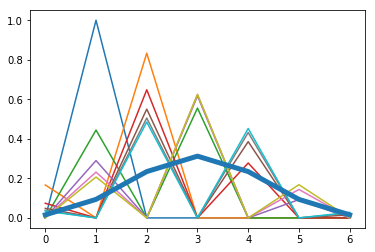

In [5]:
# ProbDistr of states iterated

q = deltastart(1,6)
maxsteps = 10
for i in range(maxsteps):
    plt.plot(q)
    q = step(q)
plt.plot(binomdistr(6),lw = 5)
plt.show()

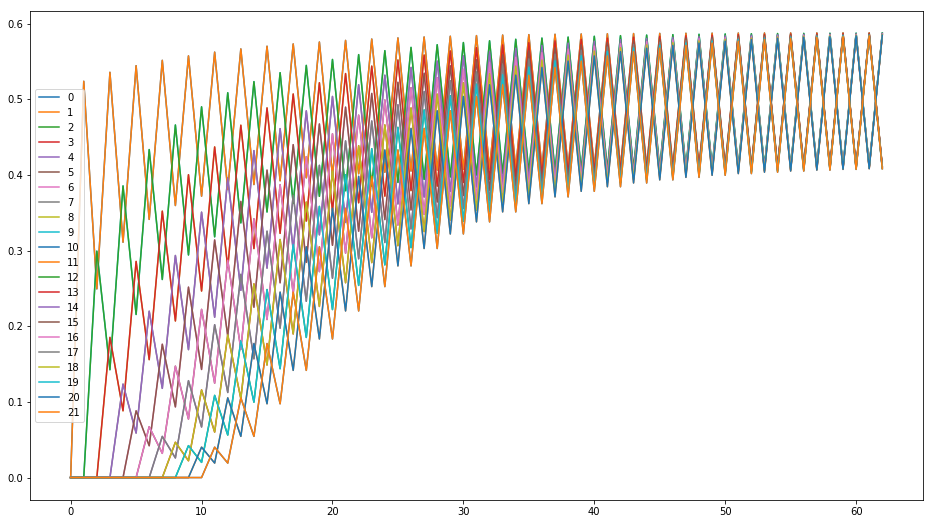

In [32]:
# Probability of flip depending on initial state

k = 21
lgnd = []
for i in range(k+1):
    p = np.array([probflipping(i,s,k) for s in range(3*k)])
    plt.plot(p)
    lgnd.append(i)
plt.legend(lgnd)
plt.show()

In [16]:
probflipping(1,21,5)

0.31248766046526516

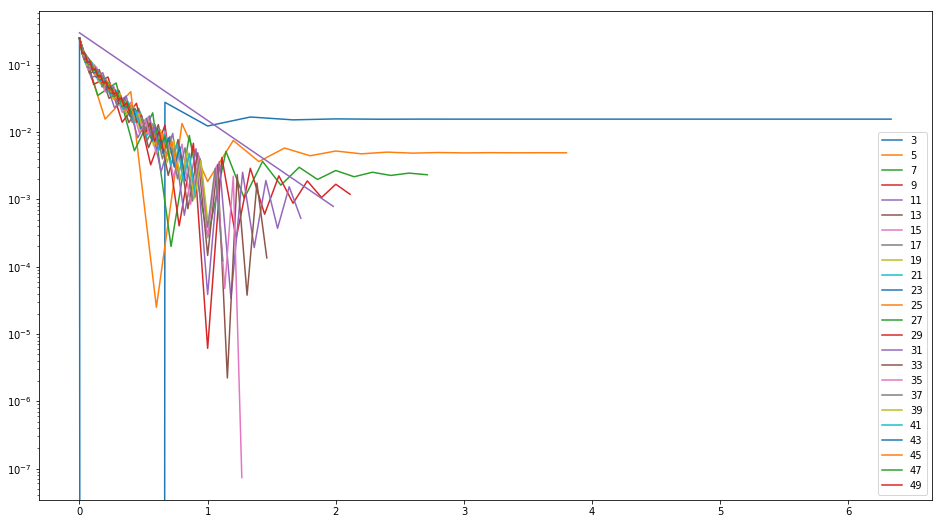

In [57]:
maxsteps = 20
lgnd = []
plt.yscale('log')
for k in np.arange(3,50,step = 2):
    totalprobflipperstep = np.array([np.dot(binomdistr(k),[probflipping(i,steps,k) for i in range(k+1)]) for steps in range(maxsteps)])
    plt.plot(np.arange(maxsteps,dtype=float)/k,(.5-totalprobflipperstep)**2)
    lgnd.append(k)

    
x = np.arange(start = 0, stop = 2, step = .02)
plt.plot(x,.3*np.exp(-3*x))
plt.legend(lgnd)
plt.show()

In [79]:
deviation = []
klist = []
for k in np.arange(3,100,step = 2):
    totalprobflipperstep = [-0.5 + np.dot(binomdistr(k),[probflipping(i,5*k,k) for i in range(k+1)]),0.5 - np.dot(binomdistr(k),[probflipping(i,5*k+1,k) for i in range(k+1)])]
    deviation.append(np.mean(totalprobflipperstep))
    klist.append(k)


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/lib64/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


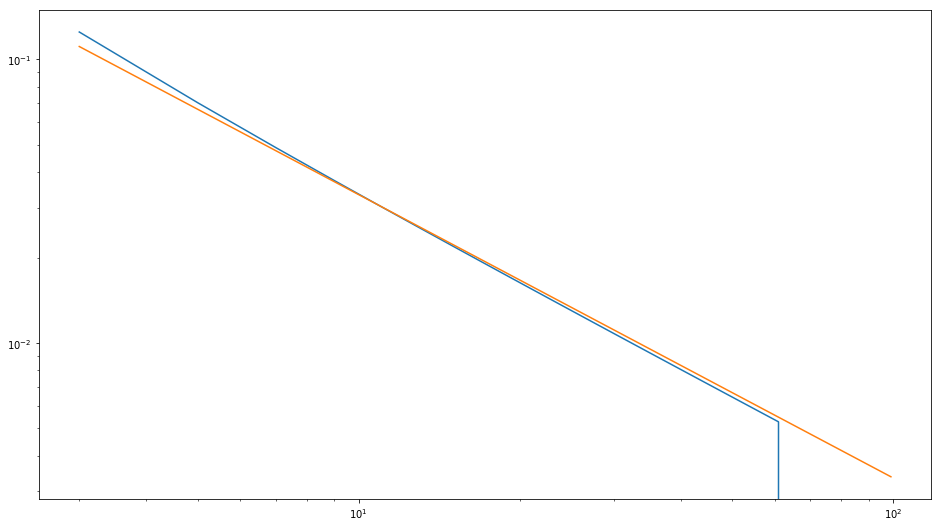

In [80]:

plt.xscale('log')
plt.yscale('log')
plt.plot(klist,deviation)
plt.plot(klist,[.3333/k for k in klist])

In [81]:
def LMSQ(x,y):
    n   = len(x)
    sx  = np.sum(x)
    sy  = np.sum(y)
    sxx = np.dot(x,x)
    sxy = np.dot(x,y)
    syy = np.dot(y,y)
    
    denom  = (n*sxx-sx*sx)
    b      = (n*sxy - sx*sy)/denom
    a      = (sy-b*sx)/n
    estim  = np.array([a,b],dtype=np.float)

    sigma2 = syy + n*a*a + b*b*sxx + 2*a*b*sx - 2*a*sy - 2*b*sxy
    cov    = sigma2 / denom * np.array([[sxx,-sx],[-sx,n]],dtype=np.float)

    return estim,cov

[-0.99209428 -1.03838656]


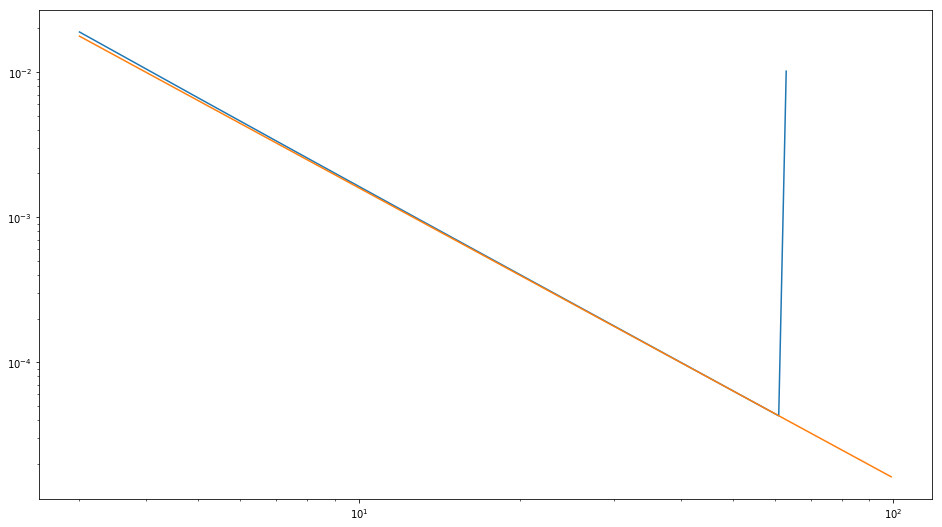

In [118]:
fit,cov = LMSQ(np.log(klist[:30]),np.log(deviation[:30]))
print(fit)

plt.plot(klist,abs(deviation-np.power(klist,-1.)/math.pi))
plt.plot(klist,np.power(klist,-2.)/(2*math.pi))
#plt.plot(klist,np.exp(fit[0] + fit[1] * np.log(klist)))
plt.yscale('log')
plt.xscale('log')